In [1]:
#First import everything
import numpy as np
from scipy import stats
import covariance_emulator
import george.kernels as kernels
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=28, family="serif")

In [3]:
#Read in the domain locations, or locations in parameter space
parameters = np.loadtxt("cosmo_parameters.txt")
#Load in the covariances
covs = np.load("new_gaussian_all_covs_withcut.npy")
N = len(covs) #number of cosmologies
Npars = len(parameters[0]) #number of parameters
dof = len(covs[0])

In [4]:
#Let's also make realizations for NPC=19
test_cov = covs[24]
input_covs = np.delete(covs, 24, axis=0)
test_parameters = parameters[24]
input_parameters = np.delete(parameters, 24, axis=0)
kernel_D = kernels.ExpSquaredKernel(metric=4., ndim=Npars)
kernel_L = kernels.ExpSquaredKernel(metric=4., ndim=Npars)
Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=19, NPC_L=19, 
                                 kernel_D = kernel_D, kernel_lp = kernel_L)
est_cov = Emu.predict(test_parameters)

In [5]:
def get_chi2_realizations(Ctrue, Cest, N_samples=100000):
    means = np.zeros(len(Ctrue))
    chi2s = np.zeros(N_samples)
    iCest = np.linalg.inv(Cest)
    for i in range(N_samples):
        x = np.random.multivariate_normal(means, Ctrue)
        #chi2s[i] = np.dot(x, np.linalg.solve(Cest, x))
        chi2s[i] = np.dot(x, np.dot(iCest, x))
    return chi2s

In [6]:
chi2_realizations = get_chi2_realizations(test_cov, est_cov, 50000)

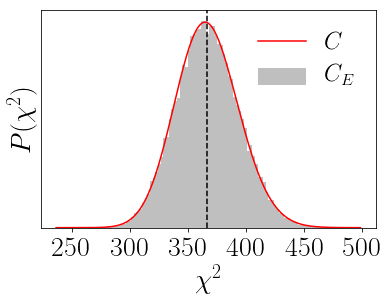

In [7]:
fig, ax = plt.subplots()

dof = len(test_cov)
x_for_chi2 = np.linspace(min(chi2_realizations)*0.92, 1.02*max(chi2_realizations), 1000)
ax.plot(x_for_chi2, stats.chi2.pdf(x_for_chi2, dof), c='r', label=r"$C$")
ax.axvline(dof, color="k", ls="--")

ax.hist(chi2_realizations, density=True, bins=100, 
        color='gray', alpha=0.5, zorder=-1, label=r"$C_{E}$")
ax.set_xlabel(r"$\chi^2$")
ax.set_ylabel(r"$P(\chi^2)$")
ax.set_yticks([])
ax.set_xticks([250, 300, 350, 400, 450, 500])
ax.legend(loc=0, fontsize=24, frameon=False)
fig.savefig("chi2_shifts.pdf", bbox_inches="tight")

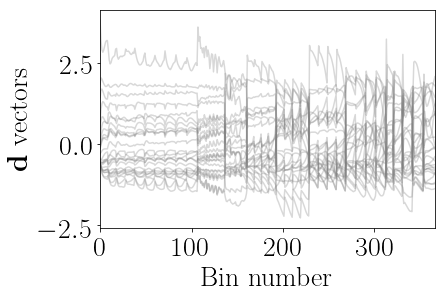

In [15]:
ds = Emu.ds
bins = np.arange(len(ds[0]))
for di in ds:
    plt.plot(bins, di, color='grey', alpha=0.3)
plt.xlabel("Bin number")
plt.ylabel(r"${\bf d}$ vectors")
plt.xlim(0, max(bins))
plt.xticks([0, 100, 200, 300])
plt.savefig("d_standardized.pdf", bbox_inches="tight", dpi=300)